In [1]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
sns.set(color_codes=True)

In [2]:
# let's set seeds to be sure we get the same thing every tim
np.random.seed(0)
torch.manual_seed(0);

In [3]:
# let's build a linear regression dataset in PyTorch
N = 10000
D = 10
X = np.random.random((N, D))
w_true = np.random.random((D, 1))

# note! data generating process doesn't have a bias, so we won't include it in our model (makes life easier)
Y = X.dot(w_true) + np.random.normal(size=(N, 1))

split = int(N * 0.9)
X_train, X_test = X[:split], X[split:]
Y_train, Y_test = Y[:split], Y[split:]

In [4]:
# let's put the data into PyTorch variables:
Xt = Variable(torch.Tensor(X_train), requires_grad=False)
Yt = Variable(torch.Tensor(Y_train), requires_grad=False)

# so we're clear about how we're sampling the initial point
weights = Variable(torch.from_numpy(np.random.random((10, 1)).astype(np.float32)), requires_grad=True)

# ok, let's set up the model:
def forward(X, Y, weights):
    loss = (Y - torch.mm(X, weights)).pow(2).mean()
    # alternatively
    # loss = F.mse_loss(torch.mm(Xt, weights), Yt)
    # though note the scaling difference
    return loss
    
def train(optimizer):
    # look! no gradient calculations
    optimizer.zero_grad()
    loss = forward(Xt, Yt, weights)
    loss.backward()
    optimizer.step()
    return loss.data[0]

Xte = Variable(torch.Tensor(X_test), requires_grad=False)
Yte = Variable(torch.Tensor(Y_test), requires_grad=False)

def test():
    loss = forward(Xte, Yte, weights)
    return loss.data[0]

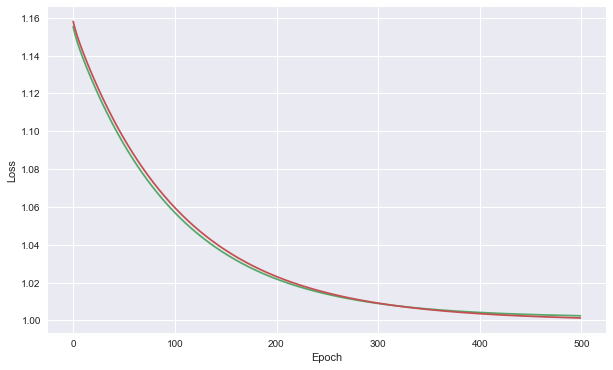

In [5]:
train_losses = np.zeros(500)
test_losses = np.zeros(500)
optimizer = torch.optim.SGD([weights], lr=0.03)
for i in range(500):
    train_losses[i] = train(optimizer)
    test_losses[i] = test()

plt.figure(figsize=(10, 6))
ax = plt.gca()    
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.plot(np.arange(500), train_losses, color='g', label='train')
ax.plot(np.arange(500), test_losses, color='r', label='test')

Similarly, we can use any of the losses in `nn.functional` to create a loss, and do backprop.

While PyTorch comes with a lot of stuff built in, sometimes you'll need to write your own 'components', which are called `Functions` in PyTorch. Here's an example:

In [6]:
class Exp(torch.autograd.Function):
    def forward(self, a):
        value = a.exp()
        self.save_for_backward(value)
        return value

    def backward(self, grad_output):
        value, = self.saved_tensors
        
        # dL/dx = dL/dy * dy/dx
        return grad_output * value

In [7]:
from torch.autograd import gradcheck
input = (Variable(torch.DoubleTensor(50,50).uniform_(), requires_grad=True),)
gradcheck(Exp(), input, eps=1e-6, atol=1e-3)

True

Here's a slightly closer to real-world example, which uses MNIST, a (relatively easy) dataset for classifying digits.

In [8]:
import torch.utils.data
from torchvision import datasets, transforms
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/', train=True, download=True, transform=transforms.ToTensor()),
    batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/', train=False, transform=transforms.ToTensor()),
    batch_size=64, shuffle=True)

Processing...
Done!


In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [10]:
model = Net()
optimizer = torch.optim.SGD(model.parameters(), lr=0.003)

In [11]:
def train(epoch):
    model.train()
    total_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {:<2} [{:<5}/{:<5} ({:<2.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))
        total_loss += loss.data[0]
    return total_loss/len(train_loader)

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss

In [12]:
losses = np.zeros((16, 2))
for epoch in range(1, 16):
    losses[epoch - 1, 0] = train(epoch)
    losses[epoch - 1, 1] = test()

Train Epoch: 1  [0    /60000 (0 %)]	Loss: 2.310014
Train Epoch: 1  [6400 /60000 (11%)]	Loss: 2.307538
Train Epoch: 1  [12800/60000 (21%)]	Loss: 2.315396
Train Epoch: 1  [19200/60000 (32%)]	Loss: 2.299222
Train Epoch: 1  [25600/60000 (43%)]	Loss: 2.301145
Train Epoch: 1  [32000/60000 (53%)]	Loss: 2.279822
Train Epoch: 1  [38400/60000 (64%)]	Loss: 2.266721
Train Epoch: 1  [44800/60000 (75%)]	Loss: 2.265357
Train Epoch: 1  [51200/60000 (85%)]	Loss: 2.233961
Train Epoch: 1  [57600/60000 (96%)]	Loss: 2.189832

Test set: Average loss: 2.1518, Accuracy: 5648/10000 (56%)

Train Epoch: 2  [0    /60000 (0 %)]	Loss: 2.160376
Train Epoch: 2  [6400 /60000 (11%)]	Loss: 2.141365
Train Epoch: 2  [12800/60000 (21%)]	Loss: 2.039308
Train Epoch: 2  [19200/60000 (32%)]	Loss: 2.054313
Train Epoch: 2  [25600/60000 (43%)]	Loss: 1.934326
Train Epoch: 2  [32000/60000 (53%)]	Loss: 1.720844
Train Epoch: 2  [38400/60000 (64%)]	Loss: 1.779583
Train Epoch: 2  [44800/60000 (75%)]	Loss: 1.780329
Train Epoch: 2  [5120

Train Epoch: 15 [25600/60000 (43%)]	Loss: 0.358166
Train Epoch: 15 [32000/60000 (53%)]	Loss: 0.457565
Train Epoch: 15 [38400/60000 (64%)]	Loss: 0.384890
Train Epoch: 15 [44800/60000 (75%)]	Loss: 0.470837
Train Epoch: 15 [51200/60000 (85%)]	Loss: 0.289884
Train Epoch: 15 [57600/60000 (96%)]	Loss: 0.335178

Test set: Average loss: 0.1809, Accuracy: 9448/10000 (94%)



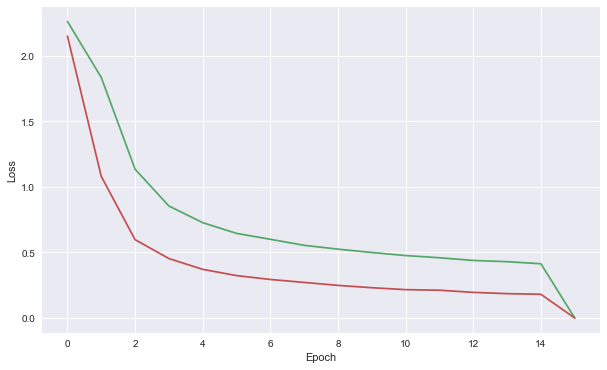

In [13]:
plt.figure(figsize=(10, 6))
ax = plt.gca()    
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.plot(np.arange(len(losses)), losses[:, 0], color='g', label='train')
ax.plot(np.arange(len(losses)), losses[:, 1], color='r', label='test')